# 0. Настройка акселератора

In [1]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

# 1. Загрузка датасета

In [2]:
import pandas as pd
import pickle

In [3]:
with open("data/clean_train.pkl", "rb") as file1:
    train_data = pickle.load(file1)
train_data

[{'prompt': 'Translate the following text from English to Spanish\n\n### English: Bank card details\n\n### Spanish: ',
  'translation': 'Detalles de tarjetas bancarias'},
 {'prompt': 'Translate the following text from English to Russian\n\n### English: Bank card details\n\n### Russian: ',
  'translation': 'Данные банковских карт'},
 {'prompt': 'Translate the following text from Spanish to English\n\n### Spanish: Detalles de tarjetas bancarias\n\n### English: ',
  'translation': 'Bank card details'},
 {'prompt': 'Translate the following text from Spanish to Russian\n\n### Spanish: Detalles de tarjetas bancarias\n\n### Russian: ',
  'translation': 'Данные банковских карт'},
 {'prompt': 'Translate the following text from Russian to English\n\n### Russian: Данные банковских карт\n\n### English: ',
  'translation': 'Bank card details'},
 {'prompt': 'Translate the following text from Russian to Spanish\n\n### Russian: Данные банковских карт\n\n### Spanish: ',
  'translation': 'Detalles de ta

In [4]:
with open("data/test.pkl", "rb") as file2:
    test_data = pickle.load(file2)
test_data

[{'prompt': 'Translate the following text from English to Spanish\n\n### English: 2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.\n\n### Spanish: ',
  'translation': '2. En la pestaña Amenazas, en la sección Categorías de los objetos detectados, seleccione las casillas que se encuentran junto a las categorías de objetos que se deben detectar.'},
 {'prompt': 'Translate the following text from English to Russian\n\n### English: 2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.\n\n### Russian: ',
  'translation': '2. На закладке Угрозы в блоке Категории обнаруживаемых объектов установите флажки рядом с категориями объектов, которые программа должна обнаруживать.'},
 {'prompt': 'Translate the following text from Spanish to English\n\n### Spanish: 2. En la pestaña Amenazas, en la sección Categorías de los objetos de

# 2. Загрузка базовой модели

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# 3. Токенизация

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [7]:
tokenized_train_dataset = [tokenizer(x["instruction"] + x["text"] + x["translation"]) for x in train_data]
tokenized_test_dataset = [tokenizer(x["instruction"] + x["text"] + x["translation"]) for x in test_data]

# 4. Настройка QLoRA

In [12]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [14]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRM

In [15]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 81108992 || all params: 3581521920 || trainable%: 2.264651559077991


In [16]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(

# 5. Тренировка модели

In [17]:
model = accelerator.prepare_model(model)

In [18]:
import transformers
from datetime import datetime

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    args=transformers.TrainingArguments(
        output_dir="llama2/peft",
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="llama2/peft/logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True                # Perform evaluation at the end of training
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1463: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
wandb: Currently logged in as: tlinguist. Use `wandb login --relogin` to force relogin


C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\peft\utils\save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,2.290000,1.731643
50,1.508600,1.358511
75,1.259900,1.240002
100,1.218300,1.210447
125,1.232300,1.190620
150,1.195800,1.176012
175,1.171500,1.165365
200,1.199100,1.154857
225,1.135300,1.148022
250,1.164100,1.138805


C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\peft\utils\save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value o

TrainOutput(global_step=500, training_loss=1.208484016418457, metrics={'train_runtime': 3052.833, 'train_samples_per_second': 0.328, 'train_steps_per_second': 0.164, 'total_flos': 1.0273463205888e+16, 'train_loss': 1.208484016418457, 'epoch': 0.21204410517387617})

In [20]:
import pandas as pd
log_history = pd.DataFrame(trainer.state.log_history)
log_history

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.2900,2.527501,0.000024,0.010602,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.010602,25,1.731643,121.6085,9.769,1.225,NaN,NaN,NaN,NaN,NaN
2,1.5086,2.804497,0.000023,0.021204,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.021204,50,1.358511,121.5766,9.772,1.226,NaN,NaN,NaN,NaN,NaN
4,1.2599,2.882079,0.000021,0.031807,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.031807,75,1.240002,121.6130,9.769,1.225,NaN,NaN,NaN,NaN,NaN
6,1.2183,2.444089,0.000020,0.042409,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.042409,100,1.210447,121.6354,9.767,1.225,NaN,NaN,NaN,NaN,NaN
8,1.2323,2.547935,0.000019,0.053011,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.053011,125,1.190620,121.6423,9.766,1.225,NaN,NaN,NaN,NaN,NaN


In [21]:
log_history.to_csv("llama2/peft/log_history.csv", index=False)

In [22]:
train_loss = log_history.loss.dropna().to_list()
eval_loss = log_history.eval_loss.dropna().to_list()
epochs = log_history.epoch.drop_duplicates().to_list()

len(train_loss), len(eval_loss), len(epochs)

(20, 20, 20)

In [23]:
train_log = pd.DataFrame({"epochs": epochs, "train_loss": train_loss})
eval_log = pd.DataFrame({"epochs": epochs, "eval_loss": eval_loss})
train_log

,epochs,train_loss
0,0.010602,2.2900
1,0.021204,1.5086
2,0.031807,1.2599
3,0.042409,1.2183
4,0.053011,1.2323
5,0.063613,1.1958
6,0.074215,1.1715
7,0.084818,1.1991
8,0.095420,1.1353
9,0.106022,1.1641


In [24]:
train_log.to_csv("llama2/peft/train_log.csv", index=False)
eval_log.to_csv("llama2/peft/eval_log.csv", index=False)

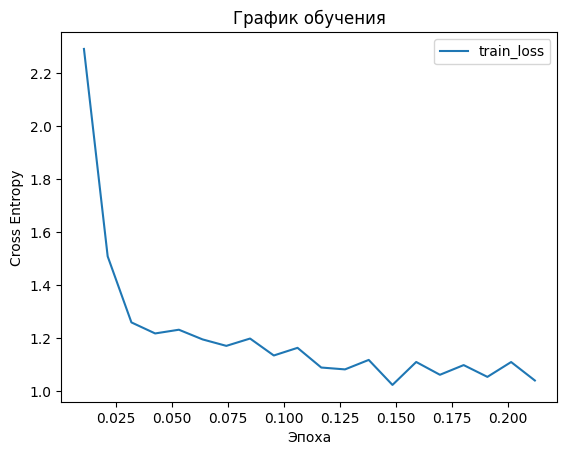

In [25]:
train_log.plot("epochs", "train_loss")
plt.title("График обучения")
plt.xlabel("Эпоха")
plt.ylabel("Cross Entropy")
plt.show()

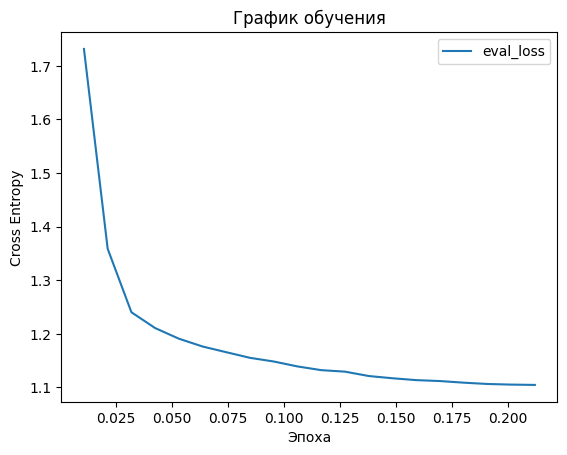

In [26]:
eval_log.plot("epochs", "eval_loss")
plt.title("График обучения")
plt.xlabel("Эпоха")
plt.ylabel("Cross Entropy")
plt.show()

# 6. Запуск обученной модели

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Llama 2 7B, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "llama2/peft/checkpoint-500")

In [29]:
import re
from tqdm import tqdm

predictions = []
for sent in tqdm(test_data):
    eval_prompt = sent["instruction"] + sent["text"]
    model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
    ft_model.eval()
    with torch.no_grad():
        result = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=60, repetition_penalty=1.15)[0], skip_special_tokens=True)
        result = re.sub(f"{eval_prompt} ", "", result)
        predictions.append(result)
predictions

100%|████████████████████████████████████████████████████████████████████████████| 1188/1188 [5:06:11<00:00, 15.46s/it]


['Translate the following text from English to Spanish\n\n### English: 2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.\n\n### Spanish: . 2. En la pestaña Amenazas, en el apartado Categorías de objetos a detectar, seleccione las casillas que se encuentran junto a las categorías de objetos a detectar.\n\n### English: Select all the categories',
 'Translate the following text from English to Russian\n\n### English: 2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.\n\n### Russian: . На странице Защита выберите соответствующие чекбоксы в категориях Объекты, которые нужно обнаружить.\n\nYou can select a single category or multiple categories. The number of selected categories is displayed below the corresponding field.',
 'Translate the following text from Spanish to English\n\n### Spanish: 2. En la pestaña Amenazas,

In [38]:
predictions_clean = [" ".join(re.sub(test_data[n]["prompt"], "", predictions[n]).split()[1:]) for n in range(len(predictions))]
predictions_clean = [re.sub("�", "", predictions_clean[n]) for n in range(len(predictions_clean))]
predictions_clean = [re.sub("\n\n### Russian:.*|\n\n### English:.*|\n\n### Spanish:.*", "", predictions_clean[n]) for n in range(len(predictions_clean))]
predictions_clean

['2. En la pestaña Amenazas, en el apartado Categorías de objetos a detectar, seleccione las casillas que se encuentran junto a las categorías de objetos a detectar. ### English: Select all the categories',
 'На странице Защита выберите соответствующие чекбоксы в категориях Объекты, которые нужно обнаружить. You can select a single category or multiple categories. The number of selected categories is displayed below the corresponding field.',
 'In the Threats tab, select the check boxes next to the categories of objects that you want to scan for threats. ### Spanish: 3. En el panel Amenazas, en la sección Objetos de los que se pueden detectar amenaz',
 'На странице Угрозы выберите соответствующие категории объектов в разделе Категории обнаруженных объектов. Выберите флажки рядом с тем или иным объектом из списка. В зависи',
 'Russian: 3. Выберите тип объекта, который вы хотите добавить в список обнаруживаемых объектов. ### English: 3. Select an object type that you want to add to the l

In [39]:
y_true = [x["translation"] for x in test_data[:len(predictions)]]
y_true

['2. En la pestaña Amenazas, en la sección Categorías de los objetos detectados, seleccione las casillas que se encuentran junto a las categorías de objetos que se deben detectar.',
 '2. На закладке Угрозы в блоке Категории обнаруживаемых объектов установите флажки рядом с категориями объектов, которые программа должна обнаруживать.',
 '2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.',
 '2. На закладке Угрозы в блоке Категории обнаруживаемых объектов установите флажки рядом с категориями объектов, которые программа должна обнаруживать.',
 '2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.',
 '2. En la pestaña Amenazas, en la sección Categorías de los objetos detectados, seleccione las casillas que se encuentran junto a las categorías de objetos que se deben detectar.',
 '· Troyanos-proxy permiten a los hackers 

In [40]:
with open("llama2/peft/preds_postprocess.pkl", "wb") as file3:
    pickle.dump(predictions_clean, file3)
with open("llama2/peft/y_true.pkl", "wb") as file4:
    pickle.dump(y_true, file4)

# 7. Оценка

## Общая оценка

In [41]:
import evaluate
bleu = evaluate.load("bleu")

In [42]:
results = bleu.compute(predictions=predictions_clean, references=y_true)
results

{'bleu': 0.10070485801084834,
 'precisions': [0.24839527227077857,
  0.12252656204308413,
  0.07374601661104559,
  0.04582363589345746],
 'brevity_penalty': 1.0,
 'length_ratio': 2.0102371202742595,
 'translation_length': 42219,
 'reference_length': 21002}

## Оценка по языку

In [43]:
import numpy as np

SIZE = len(y_true)

en2es_idx = np.arange(0, SIZE, 6)
en2ru_idx = np.arange(1, SIZE, 6)
es2en_idx = np.arange(2, SIZE, 6)
es2ru_idx = np.arange(3, SIZE, 6)
ru2en_idx = np.arange(4, SIZE, 6)
ru2es_idx = np.arange(5, SIZE, 6)

In [44]:
en2es_pred, en2ru_pred, es2en_pred, es2ru_pred, ru2en_pred, ru2es_pred = [], [], [], [], [], []
for idx, pred in enumerate(predictions_clean):
    if idx in en2es_idx:
        en2es_pred.append(pred)
    elif idx in en2ru_idx:
        en2ru_pred.append(pred)
    elif idx in es2en_idx:
        es2en_pred.append(pred)
    elif idx in es2ru_idx:
        es2ru_pred.append(pred)
    elif idx in ru2en_idx:
        ru2en_pred.append(pred)
    elif idx in ru2es_idx:
        ru2es_pred.append(pred)
    else:
        print(idx, pred)

In [45]:
len(en2es_pred), len(en2ru_pred), len(es2en_pred), len(es2ru_pred), len(ru2en_pred), len(ru2es_pred)

(198, 198, 198, 198, 198, 198)

In [46]:
en2es_true, en2ru_true, es2en_true, es2ru_true, ru2en_true, ru2es_true = [], [], [], [], [], []
for idx, pred in enumerate(y_true):
    if idx in en2es_idx:
        en2es_true.append(pred)
    elif idx in en2ru_idx:
        en2ru_true.append(pred)
    elif idx in es2en_idx:
        es2en_true.append(pred)
    elif idx in es2ru_idx:
        es2ru_true.append(pred)
    elif idx in ru2en_idx:
        ru2en_true.append(pred)
    elif idx in ru2es_idx:
        ru2es_true.append(pred)
    else:
        print(idx, pred)

In [47]:
en2es_results = bleu.compute(predictions=en2es_pred, references=en2es_true)
en2es_results

{'bleu': 0.1235309647586909,
 'precisions': [0.27172293942403175,
  0.14927462458640875,
  0.09477806788511749,
  0.06057357276869472],
 'brevity_penalty': 1.0,
 'length_ratio': 2.046228092456185,
 'translation_length': 8056,
 'reference_length': 3937}

In [48]:
en2ru_results = bleu.compute(predictions=en2ru_pred, references=en2ru_true)
en2ru_results

{'bleu': 0.05628979750418225,
 'precisions': [0.1596078431372549,
  0.06722125318663626,
  0.0395534729878721,
  0.023657741889786088],
 'brevity_penalty': 1.0,
 'length_ratio': 2.3861509669369934,
 'translation_length': 7650,
 'reference_length': 3206}

In [49]:
es2en_results = bleu.compute(predictions=es2en_pred, references=es2en_true)
es2en_results

{'bleu': 0.126272272774409,
 'precisions': [0.3007192088702427,
  0.15454685811332408,
  0.09347133757961783,
  0.05852375472628637],
 'brevity_penalty': 1.0,
 'length_ratio': 1.9874925550923168,
 'translation_length': 6674,
 'reference_length': 3358}

In [50]:
en2ru_results = bleu.compute(predictions=es2ru_pred, references=es2ru_true)
en2ru_results

{'bleu': 0.06522630650987889,
 'precisions': [0.18492840994724943,
  0.07844050947499223,
  0.045986220157026116,
  0.027134348113831898],
 'brevity_penalty': 1.0,
 'length_ratio': 2.069557080474111,
 'translation_length': 6635,
 'reference_length': 3206}

In [51]:
ru2en_results = bleu.compute(predictions=ru2en_pred, references=ru2en_true)
ru2en_results

{'bleu': 0.09900891319624561,
 'precisions': [0.26429388221841055,
  0.12325341962053243,
  0.06997879430475613,
  0.04215456674473068],
 'brevity_penalty': 1.0,
 'length_ratio': 2.083382966051221,
 'translation_length': 6996,
 'reference_length': 3358}

In [52]:
ru2es_results = bleu.compute(predictions=ru2es_pred, references=ru2es_true)
ru2es_results

{'bleu': 0.13716137155603644,
 'precisions': [0.32119845360824745,
  0.16802528697388122,
  0.10147918816649466,
  0.0646252447925939],
 'brevity_penalty': 1.0,
 'length_ratio': 1.5768351536703074,
 'translation_length': 6208,
 'reference_length': 3937}